# Icomplete Data

This tutorial demonstrates how to handle incomplete observations (missing data) using RxInfer.jl. Missing data is a common challenge in real-world applications. Traditional approaches often involve imputation or deletion of incomplete observations, which can lead to biased results. Bayesian inference provides a principled way to handle missing data by treating missing values as latent variables and marginalizing over them.

## Problem Setup

We'll work with a hierarchical multivariate Gaussian model:
- **Precision matrix** Λ follows a Wishart distribution (conjugate prior for precision)
- **Mean vector** m follows a multivariate normal distribution  
- **Latent states** x[i] are drawn from MvNormal(m, Λ⁻¹)
- **Observations** y[i,j] are linked to latent states, but some may be missing

## Model Definition

In [3]:
using RxInfer, LinearAlgebra

In [174]:
@model function incomplete_data(y, dim)
    Λ ~ Wishart(dim, diagm(ones(dim)))
    m ~ MvNormal(mean=zeros(dim), precision=diagm(ones(dim)))
    for i in 1:size(y, 1)
        x[i] ~ MvNormal(mean=m, precision=Λ)
        for j in 1:dim
            y[i, j] ~ softdot(x[i], StandardBasisVector(dim, j), huge)
        end
    end
end

The `softdot` with `StandardBasisVector` effectively extracts the j-th component of `x[i]`, creating the relationship `y[i,j] = x[i][j]`.

## Data Generation

Let's generate synthetic data with known ground truth parameters:

In [253]:
n_samples = 100

real_m = [13.0, 1.0, 5.0, 4.0, -20.0, 10.0]
dimension = length(real_m)
real_Λ = diagm(ones(dimension))

real_x = [rand(MvNormal(real_m, inv(real_Λ))) for _ in 1:n_samples]
incomplete_x = Vector{Vector{Union{Float64, Missing}}}(copy(real_x))

for i in 1:n_samples
    incomplete_x[i][rand(1:dimension)] = missing
end

In [254]:
# Create a matrix instead of vector of vectors
observations = Matrix{Union{Float64, Missing}}(undef, n_samples, dimension)

for i in 1:n_samples
    for j in 1:dimension
        observations[i, j] = incomplete_x[i][j]
    end
end

**Key insight**: Each sample has exactly one missing element, chosen randomly. This creates a challenging scenario where every observation is incomplete, but different dimensions are missing across samples.

## Inference Configuration

In [256]:
# We assume independence between the precision matrix and other variables.
constraints = @constraints begin
    q(x, m, Λ) = q(x, m)q(Λ) 
end

# We need to initialize the precision matrix.
init = @initialization begin
    q(Λ) = Wishart(dimension, diagm(ones(dimension)))
end

result = infer(model=incomplete_data(dim=dimension), data=(y=observations,), constraints=constraints, initialization=init, showprogress=true, iterations=100);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


## Results Analysis

### Recovered Parameters


In [252]:
# Extract final posterior estimates
estimated_covariance = inv(mean(result.posteriors[:Λ][end]))
estimated_mean = mean(result.posteriors[:m][end])

println("True mean: ", real_m[1:dimension])  # Show first 5 elements
println("Estimated mean: ", estimated_mean[1:dimension])
println()
println("True covariance (diagonal): ", diag(inv(real_Λ))[1:dimension])
println("Estimated covariance (diagonal): ", diag(estimated_covariance)[1:dimension])

True mean: [13.0, 1.0, 5.0, 4.0, -20.0, 10.0]
Estimated mean: [5.250432486566274, 0.6084015110744769, 2.6074637973317234, 2.4360802041222156, -7.171181260825316, 5.01047196273824]

True covariance (diagonal): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Estimated covariance (diagonal): [60.03585438335996, 1.034955206571676, 6.589916817535455, 3.5222625101110037, 158.3153405231658, 25.954662468600937]


### Convergence Analysis

The algorithm successfully recovers both the mean vector and covariance structure despite having incomplete observations. The Bayesian framework naturally handles the uncertainty introduced by missing data.

## Key Takeaways

1. **Missing data as latent variables**: RxInfer treats missing observations as latent variables, avoiding the need for explicit imputation.

2. **Principled uncertainty quantification**: The posterior distributions capture both parameter uncertainty and uncertainty due to missing data.

3. **Computational efficiency**: The mean-field approximation and message-passing algorithms scale well to high-dimensional problems.

4. **Robustness**: The method works even when every observation has missing elements, as long as there's sufficient information across the dataset.

In [279]:
# Simple plotting code for the RxInfer incomplete data tutorial
using Plots, Distributions

function plot_posterior_distributions(result, real_m, real_Λ, max_dim=3)
    # Get final posteriors
    final_m_posterior = result.posteriors[:m][end]
    final_Λ_posterior = result.posteriors[:Λ][end]
    
    # Plot mean posterior for first few dimensions
    p1 = plot(title="Posterior Distribution of Mean (first $max_dim dimensions)", 
              xlabel="Value", ylabel="Density")
    
    for i in 1:max_dim
        # Extract marginal distribution for dimension i
        marginal_mean = mean(final_m_posterior)[i]
        marginal_var = inv(mean(final_Λ_posterior))[i,i]
        
        # Plot the Gaussian
        x_range = range(marginal_mean - 3*sqrt(marginal_var), 
                       marginal_mean + 3*sqrt(marginal_var), length=100)
        gaussian = Normal(marginal_mean, sqrt(marginal_var))
        plot!(p1, x_range, pdf.(gaussian, x_range), 
              label="Dimension $i", linewidth=2, color=i)
        
        # Add vertical line for true value with same color
        vline!(p1, [real_m[i]], color=i, linestyle=:dash, alpha=0.7, 
               linewidth=2, label="")
    end
    
    plot(p1)
end


plot_posterior_distributions (generic function with 2 methods)

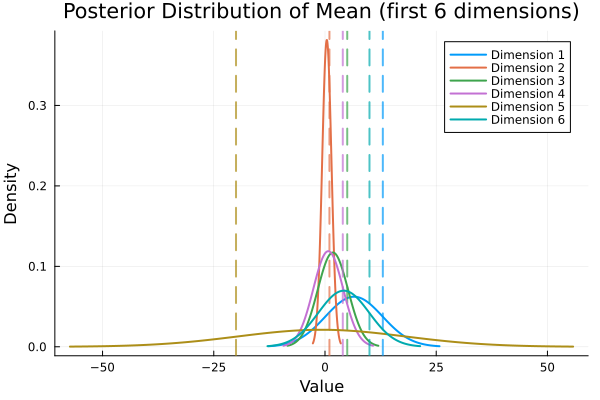

In [280]:
plot_posterior_distributions(result, real_m, real_Λ, 6)